In [118]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h2o
from h2o.automl import H2OAutoML
import re
from sklearn.feature_selection import RFE, f_regression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score
import networkx as nx
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import time
import os
import warnings
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [23]:
df = pd.read_csv("/kaggle/input/convolve-hackathon/Dev_data_to_be_shared 3/Dev_data_to_be_shared.csv")
df = df.fillna(0)

### PERFORMING PREPROCESSING STEPS

In [24]:
def find_all_zero_columns(df):
    df_filled = df.fillna(0)
    zero_columns = df_filled.columns[(df_filled == 0).all()].tolist()
    return zero_columns

In [25]:
class PreprocessingTracker:
    def __init__(self):
        # Store preprocessing states
        self.zero_columns = None
        self.threshold = 0.85
        self.cluster_info = {
            'transaction': None,
            'bureau': None,
            'bureau_enquiry': None
        }
        self.transformations = {
            'transaction': [],
            'bureau': [],
            'bureau_enquiry': []
        }
        
    def fit(self, df, zero_columns):
        """
        Parameters:
        -----------
        df : pandas.DataFrame
            Training dataframe
        zero_columns : list
            List of columns to be dropped
        """
        self.zero_columns = zero_columns
        df_transformed = df.copy()
        
        # Remove zero columns
        df_transformed = df_transformed.drop(columns=zero_columns)
        
        # Process each type of attributes
        feature_types = {
            'transaction': 'transaction_attribute',
            'bureau': 'bureau_attribute',
            'bureau_enquiry': lambda x: x.startswith('bureau_attribute') and not x.startswith('bureau_enquiry')
        }
        
        for feature_type, column_pattern in feature_types.items():
            df_transformed = self.process_feature_group(
                df_transformed, 
                feature_type, 
                column_pattern
            )
            
        return df_transformed
    
    def transform(self, df):
        """
        Parameters:
        -----------
        df : pandas.DataFrame
            New dataframe to transform
        """
        if self.zero_columns is None:
            raise ValueError("Preprocessor has not been fitted yet. Call fit() first.")
        
        df_transformed = df.copy()
        
        # Remove zero columns
        df_transformed = df_transformed.drop(columns=self.zero_columns, errors='ignore')
        
        # Apply saved transformations for each feature group
        for feature_type, cluster_info in self.cluster_info.items():
            if cluster_info is not None and not cluster_info.empty:
                df_transformed = self.apply_cluster_transformations(
                    df_transformed, 
                    cluster_info
                )
                
        return df_transformed
    
    def process_feature_group(self, df, feature_type, column_pattern):
        """Process a group of related features (transaction, bureau, etc.)"""
        # Get relevant columns
        if isinstance(column_pattern, str):
            columns = [col for col in df.columns if col.startswith(column_pattern)]
        else:  # column_pattern is a function
            columns = [col for col in df.columns if column_pattern(col)]
            
        if not columns:
            return df
            
        # Create correlation matrix
        corr_matrix = df[columns].corr()
        
        # Get highly correlated pairs
        high_correlations = self.get_highly_correlated_pairs(corr_matrix)
        
        if high_correlations.empty:
            return df
            
        # Create graph and find clusters
        graph = nx.from_pandas_edgelist(high_correlations, 'Feature 1', 'Feature 2', create_using=nx.Graph())
        clusters = list(nx.connected_components(graph))
        
        # Create cluster summary
        cluster_summary = self.create_cluster_summary(clusters, graph, high_correlations)
        
        # Save cluster information
        self.cluster_info[feature_type] = cluster_summary
        
        # Apply transformations
        return self.apply_cluster_transformations(df, cluster_summary)
    
    def get_highly_correlated_pairs(self, corr_matrix):
        """Find highly correlated feature pairs"""
        pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                correlation = abs(corr_matrix.iloc[i, j])
                if correlation > self.threshold:
                    pairs.append({
                        'Feature 1': corr_matrix.columns[i],
                        'Feature 2': corr_matrix.columns[j],
                        'Correlation': correlation
                    })
        
        return pd.DataFrame(pairs)
    
    def create_cluster_summary(self, clusters, graph, correlations):
        """Create summary of feature clusters"""
        cluster_summary = []
        
        for i, cluster in enumerate(clusters):
            subgraph = graph.subgraph(cluster)
            representative = self.select_representative(subgraph)
            avg_correlation = self.calculate_avg_correlation(subgraph, correlations)
            
            if avg_correlation is not None:
                cluster_summary.append({
                    'Cluster ID': i + 1,
                    'Representative Feature': representative,
                    'Cluster Size': len(cluster),
                    'Features': list(cluster),
                    'Avg Correlation': avg_correlation
                })
        
        summary_df = pd.DataFrame(cluster_summary)
        if not summary_df.empty:
            summary_df = summary_df.sort_values(by='Avg Correlation', ascending=False)
        
        return summary_df
    
    def select_representative(self, subgraph):
        """Select representative feature from cluster"""
        degree_centrality = nx.degree_centrality(subgraph)
        return max(degree_centrality, key=degree_centrality.get)
    
    def calculate_avg_correlation(self, subgraph, correlations):
        """Calculate average correlation within cluster"""
        edges = subgraph.edges()
        if not edges:
            return None
        
        correlations_list = []
        for u, v in edges:
            mask = ((correlations['Feature 1'] == u) & (correlations['Feature 2'] == v) |
                   (correlations['Feature 1'] == v) & (correlations['Feature 2'] == u))
            if any(mask):
                correlations_list.append(correlations.loc[mask, 'Correlation'].iloc[0])
                
        return np.mean(correlations_list) if correlations_list else None
    
    def apply_cluster_transformations(self, df, cluster_summary):
        """Apply cluster transformations to dataframe"""
        df_transformed = df.copy()
        
        if cluster_summary is not None and not cluster_summary.empty:
            for _, row in cluster_summary.iterrows():
                cluster_features = row['Features']
                representative = row['Representative Feature']
                
                # Only process if all features exist in the dataframe
                if all(feat in df_transformed.columns for feat in cluster_features):
                    # Compute mean of cluster columns
                    cluster_mean = df_transformed[cluster_features].mean(axis=1)
                    
                    # Add mean as new column
                    df_transformed[representative] = cluster_mean
                    
                    # Drop original columns except representative
                    columns_to_drop = [col for col in cluster_features if col != representative]
                    df_transformed.drop(columns=columns_to_drop, inplace=True, errors='ignore')
        
        return df_transformed

    def save_transformation(self, feature_type, cluster_features, representative_feature):
        """
        Save a transformation for later use
        
        Parameters:
        -----------
        feature_type : str
            Type of features ('transaction', 'bureau', or 'bureau_enquiry')
        cluster_features : list
            List of features in the cluster
        representative_feature : str
            Name of the representative feature for the cluster
        """
        self.transformations[feature_type].append({
            'cluster_features': cluster_features,
            'representative_feature': representative_feature
        })
    
    def transform_test_data(self, df):
        """
        Apply saved transformations to test data
        
        Parameters:
        -----------
        df : pandas.DataFrame
            Test dataframe to transform
        """
        df_transformed = df.copy()
        
        # Drop zero columns if they exist
        if self.zero_columns:
            df_transformed = df_transformed.drop(columns=self.zero_columns, errors='ignore')
        
        # Apply transformations for each feature type
        for feature_type, transformations in self.transformations.items():
            for transform in transformations:
                cluster_features = transform['cluster_features']
                representative = transform['representative_feature']
                
                # Only apply transformation if all features exist in the dataframe
                if all(feat in df_transformed.columns for feat in cluster_features):
                    # Compute mean of cluster columns
                    cluster_mean = df_transformed[cluster_features].mean(axis=1)
                    
                    # Add mean as new column
                    df_transformed[representative] = cluster_mean
                    
                    # Drop original columns except representative
                    columns_to_drop = [col for col in cluster_features if col != representative]
                    df_transformed.drop(columns=columns_to_drop, inplace=True, errors='ignore')
        
        return df_transformed

In [26]:
def preprocessing1(given_df, zero_columns, tracker=None):
    """Process transaction attributes"""
    # Initialize tracker if not provided
    if tracker is None:
        tracker = PreprocessingTracker()
    
    # Initial preprocessing
    df2 = given_df.drop(columns=zero_columns)
    transaction_columns = [col for col in df2.columns if col.startswith('transaction_attribute')]
    
    # Get correlations and clusters only for training data
    transaction_corr = df2[transaction_columns].corr()
    high_correlations_trans = tracker.get_highly_correlated_pairs(transaction_corr)
    
    if not high_correlations_trans.empty:
        # Create graph and find clusters
        graph = nx.from_pandas_edgelist(high_correlations_trans, 'Feature 1', 'Feature 2', create_using=nx.Graph())
        clusters = list(nx.connected_components(graph))
        
        # Process each cluster
        for cluster in clusters:
            subgraph = graph.subgraph(cluster)
            representative = tracker.select_representative(subgraph)
            
            # Save this transformation in tracker
            tracker.save_transformation(
                feature_type='transaction',
                cluster_features=list(cluster),
                representative_feature=representative
            )
            
            # Apply transformation to current dataframe
            cluster_mean = df2[list(cluster)].mean(axis=1)
            df2[representative] = cluster_mean
            columns_to_drop = [col for col in cluster if col != representative]
            df2.drop(columns=columns_to_drop, inplace=True)
    
    return df2, tracker


In [27]:
def preprocessing2(given_df, tracker=None):
    """Process bureau attributes"""
    if tracker is None:
        tracker = PreprocessingTracker()
    
    df2 = given_df.copy()
    bureau_columns = [col for col in df2.columns if col.startswith('bureau_attribute')]
    
    # Get correlations and clusters only for training data
    bureau_corr = df2[bureau_columns].corr()
    high_correlations_bureau = tracker.get_highly_correlated_pairs(bureau_corr)
    
    if not high_correlations_bureau.empty:
        # Create graph and find clusters
        graph = nx.from_pandas_edgelist(high_correlations_bureau, 'Feature 1', 'Feature 2', create_using=nx.Graph())
        clusters = list(nx.connected_components(graph))
        
        # Process each cluster
        for cluster in clusters:
            subgraph = graph.subgraph(cluster)
            representative = tracker.select_representative(subgraph)
            
            # Save this transformation in tracker
            tracker.save_transformation(
                feature_type='bureau',
                cluster_features=list(cluster),
                representative_feature=representative
            )
            
            # Apply transformation to current dataframe
            cluster_mean = df2[list(cluster)].mean(axis=1)
            df2[representative] = cluster_mean
            columns_to_drop = [col for col in cluster if col != representative]
            df2.drop(columns=columns_to_drop, inplace=True)
    
    return df2, tracker


In [28]:
def preprocessing3(given_df, tracker=None):
    """Process bureau enquiry attributes"""
    if tracker is None:
        tracker = PreprocessingTracker()
    
    df2 = given_df.copy()
    bureau_columns = [col for col in df2.columns if col.startswith('bureau_attribute') and not col.startswith('bureau_enquiry')]
    
    # Get correlations and clusters only for training data
    bureau_corr = df2[bureau_columns].corr()
    high_correlations_enquiry = tracker.get_highly_correlated_pairs(bureau_corr)
    
    if not high_correlations_enquiry.empty:
        # Create graph and find clusters
        graph = nx.from_pandas_edgelist(high_correlations_enquiry, 'Feature 1', 'Feature 2', create_using=nx.Graph())
        clusters = list(nx.connected_components(graph))
        
        # Process each cluster
        for cluster in clusters:
            subgraph = graph.subgraph(cluster)
            representative = tracker.select_representative(subgraph)
            
            # Save this transformation in tracker
            tracker.save_transformation(
                feature_type='bureau_enquiry',
                cluster_features=list(cluster),
                representative_feature=representative
            )
            
            # Apply transformation to current dataframe
            cluster_mean = df2[list(cluster)].mean(axis=1)
            df2[representative] = cluster_mean
            columns_to_drop = [col for col in cluster if col != representative]
            df2.drop(columns=columns_to_drop, inplace=True)
    
    return df2, tracker


In [29]:
def preprocessing(given_df, zero_columns, is_training=True, tracker=None):
    """
    Parameters:
    -----------
    given_df : pandas.DataFrame
        Input dataframe to process
    zero_columns : list
        List of columns to drop (used only during training)
    is_training : bool
        Whether this is training data or test data
    tracker : PreprocessingTracker, optional
        Tracker object to store or apply transformations
    """
    if tracker is None:
        tracker = PreprocessingTracker()
        
    if is_training:
        # For training data, process and save transformations
        first_df, tracker = preprocessing1(given_df, zero_columns, tracker)
        second_df, tracker = preprocessing2(first_df, tracker)
        final_df, tracker = preprocessing3(second_df, tracker)
    else:
        # For test data, directly apply saved transformations
        tracker.zero_columns = zero_columns
        final_df = tracker.transform_test_data(given_df)
    
    return final_df, tracker


### GETTING TRAINING AND TESTING DATA TO FIND MODEL and PREPROCESSING

In [79]:
X = df.drop("bad_flag",axis=1)
Y = df.iloc[:,1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, random_state=42, stratify=Y)

In [80]:
train_df = pd.concat((X_train,Y_train),axis=1)
test_df = pd.concat((X_test,Y_test),axis=1)

In [81]:
zero_columns = find_all_zero_columns(train_df)
tracker = PreprocessingTracker()
train_data, tracker = preprocessing(train_df, zero_columns, is_training=True)

In [82]:
test_transformed, _ = preprocessing(test_df, zero_columns, is_training=False, tracker=tracker)

In [83]:
X_test = test_transformed.drop("bad_flag",axis=1)
Y_test = test_transformed["bad_flag"]

### FINDING OPTIMAL MODELS TO FIT INTO DATA

In [84]:
def create_neural_network(input_shape):
    """Create a simple neural network with dropout"""
    model = Sequential([
        Dense(800, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [85]:

def create_balanced_subset(X_zeros, X_ones, n_zeros=5000):
    """Create a balanced subset of data"""
    # Randomly sample from zeros
    zero_indices = np.random.choice(len(X_zeros), n_zeros, replace=False)
    X_zeros_sample = X_zeros.iloc[zero_indices]
    y_zeros_sample = np.zeros(n_zeros)
    
    # Randomly sample from ones (using about 80% of ones for each model)
    n_ones = int(len(X_ones) * 0.8)
    one_indices = np.random.choice(len(X_ones), n_ones, replace=True)
    X_ones_sample = X_ones.iloc[one_indices]
    y_ones_sample = np.ones(n_ones)
    
    # Combine and shuffle
    X_combined = pd.concat([X_zeros_sample, X_ones_sample])
    y_combined = np.concatenate([y_zeros_sample, y_ones_sample])
    
    # Shuffle
    indices = np.arange(len(X_combined))
    np.random.shuffle(indices)
    
    return X_combined.iloc[indices], y_combined[indices]


In [86]:
def train_nn(final_df, n_models=11, epochs=10, batch_size=32,verbose=0):
    """Train an ensemble of neural networks"""
    # Split data into zeros and ones
    final_df = final_df.drop("account_number",axis=1)
    df_zeros = final_df[final_df['bad_flag'] == 0].drop('bad_flag', axis=1)
    df_ones = final_df[final_df['bad_flag'] == 1].drop('bad_flag', axis=1)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_zeros_scaled = pd.DataFrame(scaler.fit_transform(df_zeros), columns=df_zeros.columns)
    X_train_ones_scaled = pd.DataFrame(scaler.transform(df_ones), columns=df_ones.columns)

    n_zeros = int(df_zeros.shape[0]/n_models)
    # Train multiple models
    models = []
    for i in range(n_models):
        print(f"\nTraining model {i+1}/{n_models}")
        # Create balanced subset
        X_train_subset, y_train_subset = create_balanced_subset(
            X_train_zeros_scaled, X_train_ones_scaled, n_zeros
        )
        
        # Create and train model
        model = create_neural_network(X_train_subset.shape[1])
        
        # Use early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        
        model.fit(
            X_train_subset, y_train_subset,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.1,
            callbacks=[early_stopping],
            verbose=verbose
        )
        
        models.append(model)
    
    return models, scaler

In [88]:
trained_models, scaler = train_nn(train_data,epochs=200,n_models=30,verbose=0)


Training model 1/30

Training model 2/30

Training model 3/30

Training model 4/30

Training model 5/30

Training model 6/30

Training model 7/30

Training model 8/30

Training model 9/30

Training model 10/30

Training model 11/30

Training model 12/30

Training model 13/30

Training model 14/30

Training model 15/30

Training model 16/30

Training model 17/30

Training model 18/30

Training model 19/30

Training model 20/30

Training model 21/30

Training model 22/30

Training model 23/30

Training model 24/30

Training model 25/30

Training model 26/30

Training model 27/30

Training model 28/30

Training model 29/30

Training model 30/30


In [89]:
def train_random_forest_with_balanced_groups(data, target_column,test_size=0.5, n_splits=16, random_state=42, n_estimators=200):
    """
    Parameters:
        data (pd.DataFrame): The input data.
        target_column (str): The name of the target column.
        epochs: NOn of times model is run
        test_size (float): Fraction of data to use for testing.
        n_splits (int): Number of splits for the majority class.
        random_state (int): Random seed for reproducibility.
        n_estimators (int): Number of estimators for Random Forest.
        class_weight (dict): Class weight for the Random Forest model.
    """
    
    X = data
    y = data[target_column]
    X_train, x, _, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_test = x.drop(columns=[target_column, 'account_number'])

    
    X_ones = X_train[X_train[target_column] == 1]
    X_zeroes = X_train[X_train[target_column] == 0]

    
    
    models = []
    predictions = []
    total_iterations = 3* n_splits
    iteration_count = 0
    start_time = time.time()
    
    
    for i in range(3):
        X_shuffled = X_zeroes.sample(frac=1, random_state=random_state+i*3)
        parts = np.array_split(X_shuffled, n_splits)
        train_group = []
        for part in parts:
            X_ = pd.concat([X_ones, part])
            X_ = X_.sample(frac=1, random_state=random_state+i*3)
            Y_ = X_[target_column]
            X_ = X_.drop(columns=[target_column, 'account_number'])
            train_group.append([X_, Y_])

        
        class_weight = {
            0: 1,
            1: 3*n_splits
        }
        for train in train_group:
            X_train = train[0]
            y_train = train[1]
            rf_model = RandomForestClassifier(n_estimators=n_estimators,random_state=random_state,class_weight=class_weight).fit(X_train, y_train)
            gbm = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=0.1, max_depth=3, random_state=42).fit(X_train, y_train)
            glm = LogisticRegression(max_iter=500, random_state=42).fit(X_train, y_train)
            light_gbm = LGBMClassifier(n_estimators=n_estimators, learning_rate=0.1, max_depth=-1, random_state=42,verbose=-1).fit(X_train, y_train)
            xgboost = XGBClassifier(n_estimators=n_estimators, learning_rate=0.1, max_depth=3, use_label_encoder=False, random_state=42).fit(X_train, y_train)
            class_weight[1] -= 3
            models.append(rf_model)
            models.append(gbm)
            models.append(glm)
            models.append(light_gbm)
            models.append(xgboost)
            
            y_pred = rf_model.predict(X_test)
            predictions.append(y_pred)
            y_pred = gbm.predict(X_test)
            predictions.append(y_pred)
            y_pred = glm.predict(X_test)
            predictions.append(y_pred)
            y_pred = light_gbm.predict(X_test)
            predictions.append(y_pred)
            y_pred = xgboost.predict(X_test)
            predictions.append(y_pred)        
            iteration_count += 1
            elapsed_time = time.time() - start_time
            avg_time_per_iter = elapsed_time / iteration_count
            remaining_iters = total_iterations - iteration_count
            remaining_time = avg_time_per_iter * remaining_iters

            print(f"Iteration {iteration_count}/{total_iterations} complete.")
            print(f"Elapsed time: {elapsed_time:.2f} seconds.")
            print(f"Estimated time remaining: {remaining_time:.2f} seconds.\n")
            
            
    end_time = time.time()
    print(f"Total time taken: {end_time - start_time:.2f} seconds.")
        
    return models, predictions,x

In [90]:
def train_multi_generation_rf(initial_data, n_generations, config=None):
    """
    Parameters:
        initial_data (pd.DataFrame): Initial dataset
        n_generations (int): Number of generations to train
        config (dict): Configuration for each generation. If None, uses default values.
    """
    if config is None:
        config = {
            'gen1': {
                'test_size': 0.5,
                'n_splits': 16,
                'n_estimators': 200,
            },
            'subsequent_gens': {
                'test_size': 0.4,
                'n_splits': 10,
                'n_estimators': 200,
            }
        }
    
    all_generation_models = []
    all_generation_predictions = []
    all_generation_test_data = []
    
    current_data = initial_data.copy()
    
    for gen in range(n_generations):
        print(f"\nTraining Generation {gen + 1}")
        
        # Use first generation config or subsequent generation config
        gen_config = config['gen1'] if gen == 0 else config['subsequent_gens']
        
        # Train models for current generation
        rf_models, rf_predictions, x = train_random_forest_with_balanced_groups(
            data=current_data,
            target_column='bad_flag',
            test_size=gen_config['test_size'],
            n_splits=gen_config['n_splits'],
            random_state=42,
            n_estimators=gen_config['n_estimators']
        )
        
        # Create prediction DataFrame for current generation
        P_float = x[['account_number', 'bad_flag']]
        X_test = x.drop(columns=['account_number', 'bad_flag'])
        
        # Get predictions from all models in current generation
        for i, mod in enumerate(rf_models, 1):
            col = f"gen_{gen + 1}model{i}"
            ans = mod.predict_proba(X_test)[:, 1]
            P_float[col] = ans
        # Store results for current generation
        all_generation_models.append(rf_models)
        all_generation_predictions.append(P_float)
        all_generation_test_data.append(x)
        
        # Update data for next generation
        current_data = P_float
        
        print(f"Generation {gen + 1} complete. Shape of prediction data: {P_float.shape}")
        
    return all_generation_models, all_generation_predictions, all_generation_test_data

In [91]:
def run_multi_generation_training(initial_data, n_generations, custom_config=None):
    """
   Parameters:
        initial_data (pd.DataFrame): Initial dataset
        n_generations (int): Number of generations to train
        custom_config (dict): Optional custom configuration for generations
    """
    # Train multiple generations
    models, predictions, test_data = train_multi_generation_rf(
        initial_data=initial_data,
        n_generations=n_generations,
        config=custom_config
    )
        
    return models, predictions, test_data

# Custom configuration example:
custom_config = {
    'gen1': {
        'test_size': 0.5,
        'n_splits': 16,
        'n_estimators': 200,
    },
    'subsequent_gens': {
        'test_size': 0.5,
        'n_splits': 10,
        'n_estimators': 200,
    }
}

### TRAINING

In [92]:
models, predictions, _ = run_multi_generation_training(train_data, n_generations=4, custom_config=custom_config)


Training Generation 1
Iteration 1/48 complete.
Elapsed time: 43.82 seconds.
Estimated time remaining: 2059.60 seconds.

Iteration 2/48 complete.
Elapsed time: 86.16 seconds.
Estimated time remaining: 1981.76 seconds.

Iteration 3/48 complete.
Elapsed time: 128.48 seconds.
Estimated time remaining: 1927.19 seconds.

Iteration 4/48 complete.
Elapsed time: 171.16 seconds.
Estimated time remaining: 1882.77 seconds.

Iteration 5/48 complete.
Elapsed time: 213.21 seconds.
Estimated time remaining: 1833.61 seconds.

Iteration 6/48 complete.
Elapsed time: 254.91 seconds.
Estimated time remaining: 1784.34 seconds.

Iteration 7/48 complete.
Elapsed time: 296.67 seconds.
Estimated time remaining: 1737.62 seconds.

Iteration 8/48 complete.
Elapsed time: 338.08 seconds.
Estimated time remaining: 1690.42 seconds.

Iteration 9/48 complete.
Elapsed time: 378.80 seconds.
Estimated time remaining: 1641.47 seconds.

Iteration 10/48 complete.
Elapsed time: 419.16 seconds.
Estimated time remaining: 1592.8

### PREDICTIONS!!

In [126]:
def predict_with_generations(data, generation_models,ignore_columns=None):
    """
    Parameters:
        data (pd.DataFrame): Complete dataset to predict on
        generation_models (list): List of lists of models from each generation
        target_column (str): Name of the target column
        ignore_columns (list): Columns to ignore in prediction (e.g., ['account_number'])
    """
    if ignore_columns is None:
        ignore_columns = ['account_number']
    
    # Initialize results DataFrame with necessary columns
    results = pd.DataFrame()
    if 'account_number' in data.columns:
        results['account_number'] = data['account_number']
    
    # Keep track of feature columns for each generation
    current_data = data.copy()
    
    # Process each generation
    for gen_idx, gen_models in enumerate(generation_models):
        print(f"\nProcessing Generation {gen_idx + 1}")
        
        # Prepare features for current generation
        if gen_idx == 0:
            # For first generation, use original features
            X = current_data.drop(columns= ignore_columns)
        else:
            # For subsequent generations, use previous generation's predictions
            X = current_data.drop(columns=[col for col in current_data.columns 
                                         if col not in [f"gen_{gen_idx}model{i}" 
                                                      for i in range(1, len(generation_models[gen_idx-1]) + 1)]])
        
        # Get predictions from all models in current generation
        for model_idx, model in enumerate(gen_models, 1):
            # Generate probabilities for class 0
            prob_0 = model.predict_proba(X)[:, 0]
            
            # Store predictions
            col_name = f"gen_{gen_idx + 1}model{model_idx}_prob_0"
            results[col_name] = prob_0
            
            # Add predictions to current_data for next generation
            current_data[f"gen_{gen_idx + 1}model{model_idx}"] = 1 - prob_0  # prob of class 1 for next gen
            
    return results

In [127]:
def ensemble_predict(models, X_test_init,scaler,results):
    X_test_init = X_test_init.drop("account_number",axis=1)
    X_test = pd.DataFrame(scaler.transform(X_test_init), columns=X_test_init.columns)
    predictions = np.zeros((len(X_test), len(models)))
    model_weights = np.zeros(len(models))  # To store weights for each model

    
    # Get predictions from each model
    col_name = "nn_model_"
    for i in range(len(models)):
        model = models[i]
        # Predict probabilities for the positive class
        model_predictions = model.predict(X_test)[:, 0]
        predictions[:, i] = model_predictions
        col = col_name = f"gen_{33}model{i+1}_prob_0"
        results[col] = predictions[:,i]
        
        # Calculate the weight for the model as the proportion of 1s predicted
        model_weights[i] = np.sum(model_predictions < 0.5) / len(X_test)
    
    # Normalize weights so they sum to 1
    model_weights /= np.sum(model_weights)
    
    # Compute the weighted mean of predictions
    final_predictions = np.dot(predictions, model_weights)

    # Convert probabilities to class predictions
    class_predictions = (final_predictions < 0.5).astype(int)
    class_predictions = pd.DataFrame(class_predictions)
    final_predictions = pd.DataFrame(final_predictions)
    
    return final_predictions, class_predictions,results
    

In [128]:
def calculate_final_probabilities(prediction_results, method='mean'):
    """
    Parameters:
        prediction_results (pd.DataFrame): DataFrame with all model predictions
        method (str): Aggregation method ('mean', 'weighted_mean', 'median', 'max', 'min')
    """
    # Get all probability columns
    prob_columns = [col for col in prediction_results.columns if 'prob_0' in col]
    
    if method == 'mean':
        final_probs = prediction_results[prob_columns].mean(axis=1)
    elif method == 'weighted_mean':
        # Give more weight to later generations
        weights = {}
        for col in prob_columns:
            match = re.search(r'gen_(\d+)', col)
            if match:
                gen_num = int(match.group(1))
                weights[col] = gen_num  # Weight by generation number
            else:
                raise ValueError(f"Could not extract generation number from column name: {col}")
        
        weighted_sum = sum(prediction_results[col] * weights[col] for col in prob_columns)
        total_weight = sum(weights.values())
        final_probs = weighted_sum / total_weight

    elif method == 'median':
        final_probs = prediction_results[prob_columns].median(axis=1)
    elif method == 'max':
        final_probs = prediction_results[prob_columns].max(axis=1)
    elif method == 'min':
        final_probs = prediction_results[prob_columns].min(axis=1)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    return final_probs

In [129]:
def get_final_predictions(data, generation_models,nn_models, scaler,aggregation_method='mean'):
    """
    Parameters:
        data (pd.DataFrame): Complete dataset
        generation_models (list): List of lists of models from each generation
        aggregation_method (str): Method to aggregate probabilities
    """
    # Get predictions from all models
    all_predictions = predict_with_generations(data, generation_models)
    _,_,all_predictions = ensemble_predict(nn_models, data ,scaler,all_predictions)
    
    # Calculate final probabilities
    final_probs = calculate_final_probabilities(all_predictions, method=aggregation_method)
    
    # Create final results DataFrame
    final_results = pd.DataFrame({
        'account_number': all_predictions['account_number'] if 'account_number' in all_predictions.columns else range(len(final_probs)),
        'final_probability_0': final_probs
    })
    
    return final_results, all_predictions

In [130]:
# After training your models:
final_results, detailed_predictions = get_final_predictions(
    data=X_test,
    generation_models=models,
    nn_models = trained_models,scaler=scaler,
    aggregation_method='weighted_mean'
)

# Save results
final_results


Processing Generation 1

Processing Generation 2

Processing Generation 3

Processing Generation 4
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

,account_number,final_probability_0
59078,59079,0.991778
40555,40556,0.982795
58319,58320,0.935080
61945,61946,0.886893
24962,24963,0.960622
...,...,...
80891,80892,0.957952
11141,11142,0.660771
23727,23728,0.963686
52595,52596,0.882635


In [135]:
# Convert probabilities to binary classification (0 or 1)
# NOTE THAT HERE WE HAVE PROBABILITY 1 for 0 and PROBABILITY 0 for 1 !!, REQUIRED OUTPUT FOR val TEST is given below with req changes
final_results['final_prediction'] = final_results['final_probability_0'].apply(lambda x: 0 if x >= 0.50 else 1)

# Display the updated DataFrame
accuracy = accuracy_score(Y_test, final_results['final_prediction'])
f1 = f1_score(Y_test, final_results['final_prediction'], average='weighted')

print("Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(Y_test, final_results['final_prediction']))

Performance Metrics:
Accuracy: 0.9672
F1 Score: 0.9714
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4772
           1       0.12      0.20      0.15        69

    accuracy                           0.97      4841
   macro avg       0.55      0.59      0.57      4841
weighted avg       0.98      0.97      0.97      4841



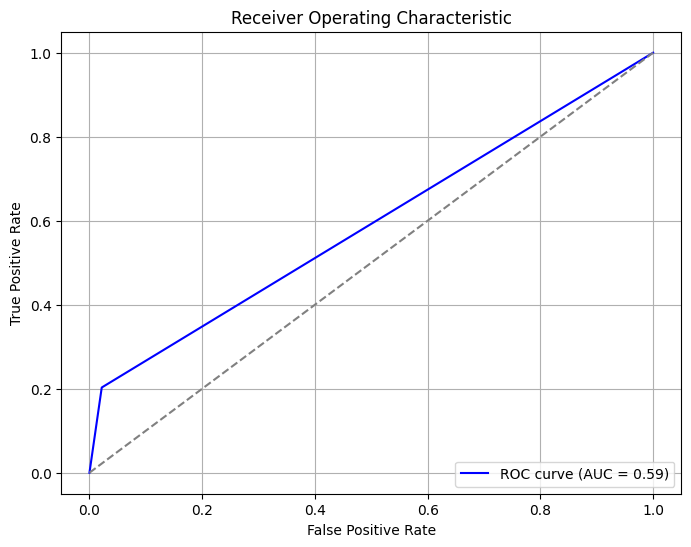

In [136]:
fpr, tpr, thresholds = roc_curve(Y_test, final_results['final_prediction'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()


### PREPROCESSING AND TRAINING FINAL VALIDATION DATA

In [105]:
final_df = pd.read_csv("/kaggle/input/convolve-hackathon/validation_data_to_be_shared 3/validation_data_to_be_shared.csv")
final_df = final_df.fillna(0)

In [111]:
final_df.shape

(41792, 1215)

In [106]:
final_transformed, _ = preprocessing(final_df, zero_columns, is_training=False, tracker=tracker)
X_final = final_transformed

In [107]:
output_results,ensemble_predict = get_final_predictions(
    data=X_final,
    generation_models=models,
    nn_models = trained_models,scaler=scaler,
    aggregation_method='weighted_mean'
)


Processing Generation 1

Processing Generation 2

Processing Generation 3

Processing Generation 4
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/st

In [109]:
output_results['final_prediction_binary'] = output_results['final_probability_0'].apply(lambda x: 0 if x >= 0.50 else 1)
output_results['bad_flag'] = output_results['final_probability_0'].apply(lambda x: 1-x)
output_results

,account_number,final_probability_0,final_prediction_binary,final_probability_1,bad_flag
0,100001,0.759023,0,0.240977,0.240977
1,100002,0.968735,0,0.031265,0.031265
2,100003,0.981263,0,0.018737,0.018737
3,100004,0.935902,0,0.064098,0.064098
4,100005,0.758247,0,0.241753,0.241753
...,...,...,...,...,...
41787,141788,0.919839,0,0.080161,0.080161
41788,141789,0.935476,0,0.064524,0.064524
41789,141790,0.882140,0,0.117860,0.117860
41790,141791,0.904579,0,0.095421,0.095421


In [112]:
output_results["final_prediction_binary"].value_counts()

final_prediction_binary
0    40769
1     1023
Name: count, dtype: int64

In [114]:
output_results.drop(["final_probability_0","final_prediction_binary","final_probability_1"],axis=1,inplace=True)

In [117]:
output_results.to_csv("/kaggle/working/outputs.csv",index=False)